CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in df: 1051
Rows that have all features = NaN: 21
TRAIN rows: 966
VAL   rows: 64
TEST  rows: 21

=== Training LSTM model ===
[LSTM] Epoch 100, Train=0.000508, Val=0.001885
[LSTM] Epoch 200, Train=0.000324, Val=0.001240
[LSTM] Epoch 300, Train=0.000767, Val=0.001007
[LSTM] Epoch 400, Train=0.000224, Val=0.000611
Early stopping triggered
[LSTM] Early stopping at epoch 452
LSTM has no real test data => skip MAPE

=== Training GRU model ===


/tmp/ipykernel_3239407/1434472731.py:401: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


[GRU] Epoch 100, Train=0.000348, Val=0.000921
[GRU] Epoch 200, Train=0.000222, Val=0.002124
Early stopping triggered
[GRU] Early stopping at epoch 255
GRU has no real test data => skip MAPE

=== Training RNN model ===


/tmp/ipykernel_3239407/1434472731.py:401: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


[RNN] Epoch 100, Train=0.000600, Val=0.002405
[RNN] Epoch 200, Train=0.000480, Val=0.000577
[RNN] Epoch 300, Train=0.000460, Val=0.000432
[RNN] Epoch 400, Train=0.001557, Val=0.000580
[RNN] Epoch 500, Train=0.000297, Val=0.000464
RNN has no real test data => skip MAPE

=== Training CNN model ===


/tmp/ipykernel_3239407/1434472731.py:401: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


[CNN] Epoch 100, Train=0.000401, Val=0.005511
[CNN] Epoch 200, Train=0.001500, Val=0.009630
Early stopping triggered
[CNN] Early stopping at epoch 274
CNN has no real test data => skip MAPE


/tmp/ipykernel_3239407/1434472731.py:401: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


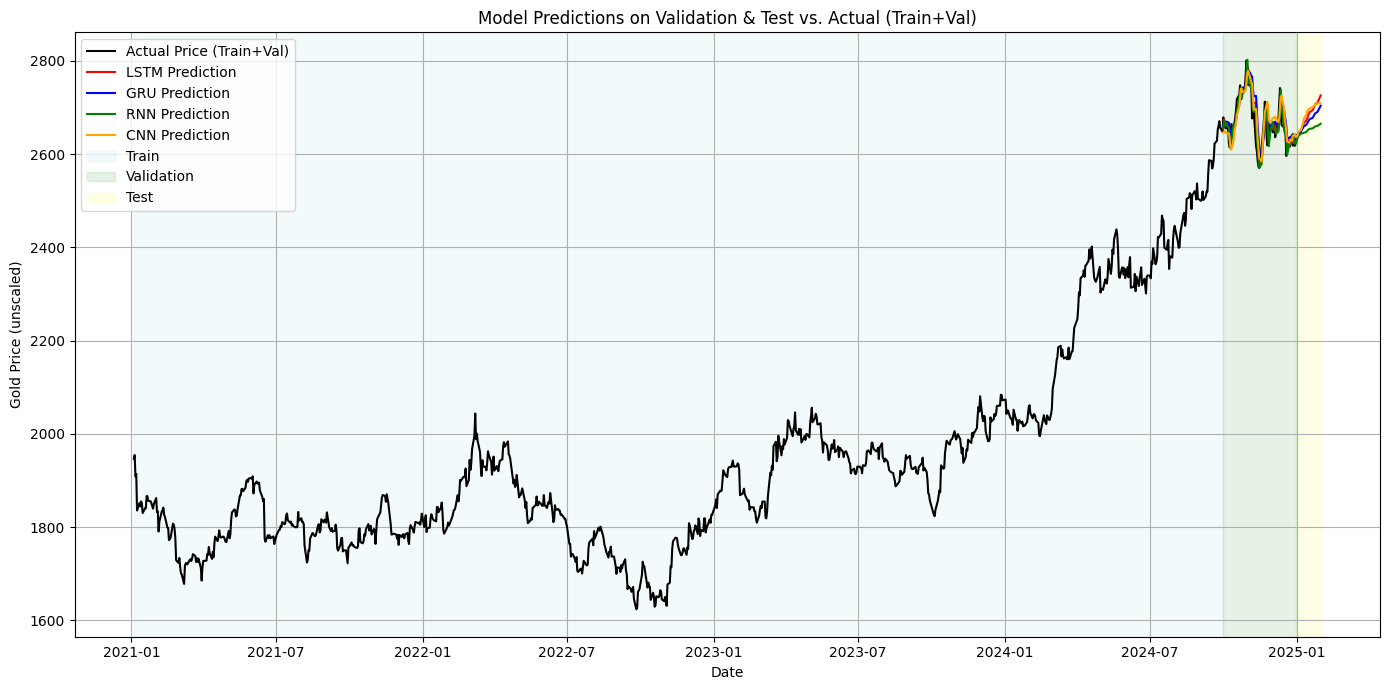

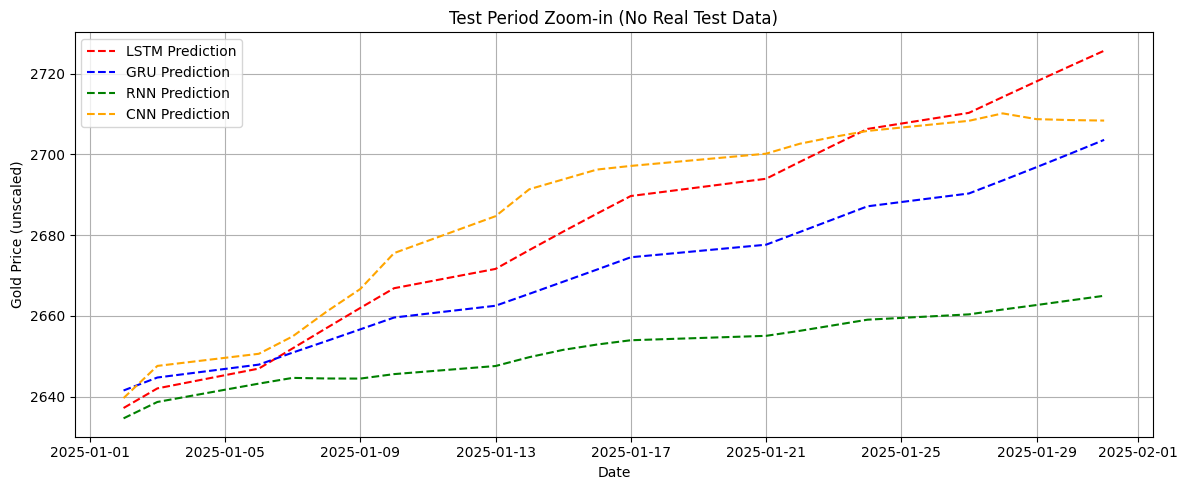

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
from sklearn.metrics import mean_absolute_percentage_error

# ------------------------------------------------------------------------
# 1. Set random seeds
# ------------------------------------------------------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

###############################################################
# Global hyperparameters
###############################################################
# You can change these two variables in one place.

WINDOW_SIZE = 30
NUM_EPOCHS  = 500

###############################################################
# Explanation:
# The key fix is in the CNN branch: we must compute the conv
# output length dynamically from 'WINDOW_SIZE' rather than
# hard-coding 30.
###############################################################

# ------------------------------------------------------------------------
# 2. Load & Clean CSV
# ------------------------------------------------------------------------
features = ["Price", "Open", "High", "Low"]
csv_file = "Gold Futures Historical Data_5Yr_Blind Test.csv"

df = pd.read_csv(csv_file)

# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Drop columns we don't need
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

# Remove commas and parse numeric
for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values(by="Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in df:", len(df))
print("Rows that have all features = NaN:",
      df[features].isna().all(axis=1).sum())

# ------------------------------------------------------------------------
# 3. Date cutoffs: TRAIN, VAL, TEST
# ------------------------------------------------------------------------
train_cutoff = pd.to_datetime("2024-10-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-02")

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

# ------------------------------------------------------------------------
# 4. Fit MinMaxScaler on TRAIN only
# ------------------------------------------------------------------------
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

df_val_no_nan = df_val_scaled.dropna(subset=features)
if not df_val_no_nan.empty:
    df_val_scaled.loc[df_val_no_nan.index, features] = scaler.transform(df_val_no_nan[features])

train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------------------------
# 5A. Create the training sequences
# ------------------------------------------------------------------------
def make_sequences(df_subset, window=WINDOW_SIZE):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window : i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

# Build training data
# only use scaled rows that have non-NaN features

train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)

X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# ------------------------------------------------------------------------
# 5B. "Half-blind" validation function
# (We do not store predictions here, only compute loss)
# We'll add a separate function below to store validation predictions.
# ------------------------------------------------------------------------
def half_blind_validation_loss(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = df_work.loc[val_mask, "Date"].unique()
    val_dates = np.sort(val_dates)

    model.eval()
    criterion = nn.MSELoss()

    losses = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue

            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue

            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu()[0]

            true_vals = df_work.loc[idx_current, features]
            true_vals = pd.to_numeric(true_vals, errors="coerce").astype(float)
            true_vals = true_vals.values
            if np.isnan(true_vals).any():
                continue

            loss = criterion(pred_4_scaled, torch.tensor(true_vals).float())
            losses.append(loss.item())

    if len(losses) == 0:
        return 999999.0
    return np.mean(losses)

# ------------------------------------------------------------------------
# 5C. "Half-blind" validation predictions (to visualize model in val set)
# We'll not overwrite the DataFrame, so we remain half-blind.
# ------------------------------------------------------------------------
def half_blind_validation_preds(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    """Return a DataFrame of day-by-day predictions for the validation set."""
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = df_work.loc[val_mask, "Date"].unique()
    val_dates = np.sort(val_dates)

    model.eval()
    preds = []  # store day, predicted scaled[4]

    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue

            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue

            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu().numpy()[0]

            # We do NOT overwrite day d with predictions (half-blind)
            # We just store them.
            preds.append((d, *pred_4_scaled))

    # Build a DataFrame
    val_pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Val_Pred_Price_scl", "Val_Pred_Open_scl",
                 "Val_Pred_High_scl",  "Val_Pred_Low_scl"]
    )
    val_pred_df.sort_values("Date", inplace=True)
    # Inverse transform
    scaled_array = val_pred_df[["Val_Pred_Price_scl", "Val_Pred_Open_scl",
                                "Val_Pred_High_scl",  "Val_Pred_Low_scl"]].values
    unscaled_array = scaler.inverse_transform(scaled_array)

    val_pred_df["Val_Pred_Price_unsc"] = unscaled_array[:,0]
    val_pred_df["Val_Pred_Open_unsc"]  = unscaled_array[:,1]
    val_pred_df["Val_Pred_High_unsc"]  = unscaled_array[:,2]
    val_pred_df["Val_Pred_Low_unsc"]   = unscaled_array[:,3]

    return val_pred_df

# ------------------------------------------------------------------------
# 6. Define the model class with dynamic CNN out-len
# ------------------------------------------------------------------------
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=WINDOW_SIZE):
        super().__init__()
        self.model_type = model_type
        self.window_width = window_width

        if model_type == "CNN":
            # Two conv layers, kernel_size=3 (no padding, stride=1)
            self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)

            # Dynamically compute the output dimension after the conv layers:
            # Create a dummy input of shape [batch_size, channels, seq_length]
            with torch.no_grad():
                dummy_input = torch.zeros(1, 4, self.window_width)
                dummy_output = self.conv2(F.relu(self.conv1(dummy_input)))
                # Flatten all dimensions except batch: (channels * seq_length)
                conv_output_size = dummy_output.shape[1] * dummy_output.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)

        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=2,
                               batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "RNN":
            self.rnn = nn.RNN(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, nonlinearity="relu", dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=3,
                               batch_first=True, dropout=0.2)
            self.bn = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(128, 4)
        else:
            raise ValueError("Invalid model_type")

    def forward(self, x):
        # x: [batch, window_width, 4]
        if self.model_type == "CNN":
            x = x.permute(0, 2, 1)  # [batch, channels=4, seq_len=window_width]
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == "EnhancedLSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out


class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ------------------------------------------------------------------------
# 7. Inverse transform helper
# ------------------------------------------------------------------------
def inverse_transform_4cols(y_4):
    return scaler.inverse_transform(y_4)

# ------------------------------------------------------------------------
# 8. Training function
# ------------------------------------------------------------------------
def train_model(model_type="LSTM", num_epochs=NUM_EPOCHS):
    """
    Builds a model of the chosen type with window=WINDOW_SIZE,
    trains for num_epochs, and returns the best model.
    """
    model = BaseModel(model_type, window_width=WINDOW_SIZE).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=150)
    early_stopping = EarlyStopping(patience=150)

    best_val_loss = float("inf")
    best_path = f"best_{model_type}_TotalBlind_V1.pt"

    if os.path.exists(best_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_path, map_location=device))
        print(f"[{model_type}] Loaded existing model from {best_path}")

    for epoch in range(num_epochs):
        # Train
        model.train()
        train_losses = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)

        # Validate (compute half-blind loss)
        val_loss = half_blind_validation_loss(
            model,
            df_scaled,
            val_start=train_cutoff,
            val_end=val_cutoff,
            window=WINDOW_SIZE
        )
        scheduler.step(val_loss)
        early_stopping(val_loss)

        # Save best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_path)

        if early_stopping.early_stop:
            print(f"[{model_type}] Early stopping at epoch {epoch+1}")
            break

        if (epoch + 1) % 100 == 0:
            print(f"[{model_type}] Epoch {epoch+1}, Train={avg_train_loss:.6f}, Val={val_loss:.6f}")

    model.load_state_dict(torch.load(best_path, map_location=device))
    return model

# ------------------------------------------------------------------------
# 9. Validation predictions + Test predictions
#    We do separate walk-forward for val (half-blind, no overwrite)
#    and test (fully-blind, overwrite) to get final predictions.
# ------------------------------------------------------------------------
def half_blind_validation_preds_df(model, df_all_scaled, val_start, val_end, window=WINDOW_SIZE):
    """Get day-by-day half-blind predictions for the validation set."""
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = df_work.loc[val_mask, "Date"].unique()
    val_dates = np.sort(val_dates)

    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue

            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue

            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu().numpy()[0]

            preds.append((d, *pred_4_scaled))

    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)

    # inverse transform
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = inverse_transform_4cols(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]

    return pred_df


def walk_forward_test(model, df_all_scaled, test_start, window=WINDOW_SIZE):
    """Fully-blind multi-step forecast on test (overwrite)"""
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    preds = []
    test_dates = df_work[df_work["Date"] >= test_start]["Date"].unique()
    test_dates = np.sort(test_dates)

    model.eval()
    with torch.no_grad():
        for d in test_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue

            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue

            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            y_pred_4_scaled = model(X_input).cpu().numpy()[0]

            # Overwrite day d
            df_work.loc[idx_current, features] = y_pred_4_scaled
            preds.append((d, *y_pred_4_scaled))

    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)

    # inverse transform
    scaled_array = pred_df[["Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]].values
    unscaled_array = inverse_transform_4cols(scaled_array)
    pred_df["Pred_Price_unscaled"] = unscaled_array[:,0]
    pred_df["Pred_Open_unscaled"]  = unscaled_array[:,1]
    pred_df["Pred_High_unscaled"]  = unscaled_array[:,2]
    pred_df["Pred_Low_unscaled"]   = unscaled_array[:,3]

    return pred_df

# ------------------------------------------------------------------------
# 10. Evaluate & Plot
# ------------------------------------------------------------------------
def evaluate_and_plot_all_models(results_dict):
    df_real = df_scaled[["Date","Price","Open","High","Low"]].copy()
    df_real.sort_values("Date", inplace=True)

    # Inverse transform real Price only up to test
    mask_trainval = (df_real["Date"] < test_cutoff)
    df_real_plot = df_real.loc[mask_trainval].copy()
    real_4_scaled = df_real_plot[features].values
    real_4_unscaled = inverse_transform_4cols(real_4_scaled)
    df_real_plot["Real_Price_unscaled"] = real_4_unscaled[:,0]

    # We'll merge each model's val+test predictions into the same col "Pred_{model}"

    plt.figure(figsize=(14,7))

    # Plot real Price (train+val only)
    plt.plot(df_real_plot["Date"], df_real_plot["Real_Price_unscaled"],
             color="black", label="Actual Price (Train+Val)")

    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta"
    }

    for model_name, info in results_dict.items():
        # we already merged them below, but let's do it systematically.
        pass

    # Because we want to see final merged df, let's do the merges now.
    merged_df = df_real.copy()
    merged_df.sort_values("Date", inplace=True)

    for model_name, info in results_dict.items():
        # We have 'val_pred_df' (validation) and 'test_pred_df' (test)
        val_pred_df = info["val_pred_df"]
        test_pred_df = info["test_pred_df"]

        # unify them into single column: "Pred_{model_name}"
        # We'll create a combined pred_df.
        frames = []
        if val_pred_df is not None:
            frames.append(val_pred_df.rename(columns={
                "Pred_Price_unscaled": f"Pred_{model_name}",
            }))
        if test_pred_df is not None:
            frames.append(test_pred_df.rename(columns={
                "Pred_Price_unscaled": f"Pred_{model_name}",
            }))
        if not frames:
            # no predictions?
            continue
        combined_df = pd.concat(frames, ignore_index=True)
        combined_df = combined_df[["Date", f"Pred_{model_name}"]].copy()
        combined_df.drop_duplicates("Date", keep="last", inplace=True)
        combined_df.sort_values("Date", inplace=True)

        merged_df = pd.merge(merged_df, combined_df, on="Date", how="left")

    # Now we can plot the final columns.
    for model_name, info in results_dict.items():
        col = f"Pred_{model_name}"
        if col in merged_df.columns:
            plt.plot(
                merged_df["Date"],
                merged_df[col],
                color=color_map.get(model_name,"gray"),
                linestyle="-",
                label=f"{model_name} Prediction"
            )

    # highlight regions
    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, merged_df["Date"].max(), color="yellow", alpha=0.1, label="Test")

    plt.title("Model Predictions on Validation & Test vs. Actual (Train+Val)")
    plt.xlabel("Date")
    plt.ylabel("Gold Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Zoom in on test portion if you like
    df_test_zoom = merged_df[merged_df["Date"] >= test_cutoff]
    if not df_test_zoom.empty:
        plt.figure(figsize=(12,5))
        # We do NOT plot real Price in test, as user requested
        for model_name, info in results_dict.items():
            col = f"Pred_{model_name}"
            if col in df_test_zoom.columns:
                plt.plot(
                    df_test_zoom["Date"],
                    df_test_zoom[col],
                    color=color_map.get(model_name,"gray"),
                    linestyle="--",
                    label=f"{model_name} Prediction"
                )

        plt.title("Test Period Zoom-in (No Real Test Data)")
        plt.xlabel("Date")
        plt.ylabel("Gold Price (unscaled)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ------------------------------------------------------------------------
# 11. MAIN
# ------------------------------------------------------------------------
if __name__ == "__main__":
    model_types = ["LSTM", "GRU", "RNN", "CNN"]
    results_dict = {}

    for mt in model_types:
        print(f"\n=== Training {mt} model ===")
        model = train_model(mt, num_epochs=NUM_EPOCHS)

        # We'll produce predictions for val & test.
        val_pred_df = half_blind_validation_preds_df(
            model,
            df_scaled,
            val_start=train_cutoff,
            val_end=val_cutoff,
            window=WINDOW_SIZE
        )
        # rename columns to unify
        val_pred_df.rename(columns={
            "Pred_Price_unscaled":    "Pred_Price_unscaled",
        }, inplace=True)

        test_pred_df = walk_forward_test(
            model,
            df_all_scaled=df_scaled,
            test_start=test_cutoff,
            window=WINDOW_SIZE
        )

        # store in results
        results_dict[mt] = {
            "val_pred_df": val_pred_df,
            "test_pred_df": test_pred_df
        }
        print(f"{mt} has no real test data => skip MAPE")

    evaluate_and_plot_all_models(results_dict)

CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in df: 1051
Rows that have all features = NaN: 21
TRAIN rows: 966
VAL   rows: 64
TEST  rows: 21

=== Training LSTM model ===
[LSTM] Epoch 100, Train=0.000508, Val=0.001885
[LSTM] Epoch 200, Train=0.000324, Val=0.001240
[LSTM] Epoch 300, Train=0.000767, Val=0.001007
[LSTM] Epoch 400, Train=0.000224, Val=0.000611
Early stopping triggered
[LSTM] Early stopping at epoch 452
LSTM has no real test data => skip MAPE

=== Training GRU model ===


/tmp/ipykernel_3259204/233392427.py:436: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


[GRU] Epoch 100, Train=0.000348, Val=0.000921
[GRU] Epoch 200, Train=0.000222, Val=0.002124
Early stopping triggered
[GRU] Early stopping at epoch 255
GRU has no real test data => skip MAPE

=== Training RNN model ===


/tmp/ipykernel_3259204/233392427.py:436: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


[RNN] Epoch 100, Train=0.000600, Val=0.002405
[RNN] Epoch 200, Train=0.000480, Val=0.000577
[RNN] Epoch 300, Train=0.000460, Val=0.000432
[RNN] Epoch 400, Train=0.001557, Val=0.000580
[RNN] Epoch 500, Train=0.000297, Val=0.000464
[RNN] Epoch 600, Train=0.000292, Val=0.000493
Early stopping triggered
[RNN] Early stopping at epoch 624
RNN has no real test data => skip MAPE

=== Training CNN model ===


/tmp/ipykernel_3259204/233392427.py:436: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


[CNN] Epoch 100, Train=0.000459, Val=0.001870
[CNN] Epoch 200, Train=0.001089, Val=0.000964
[CNN] Epoch 300, Train=0.000220, Val=0.001216
[CNN] Epoch 400, Train=0.000168, Val=0.000850
[CNN] Epoch 500, Train=0.001261, Val=0.001105
[CNN] Epoch 600, Train=0.000158, Val=0.000708
[CNN] Epoch 700, Train=0.000381, Val=0.000644
[CNN] Epoch 800, Train=0.000156, Val=0.000340
[CNN] Epoch 900, Train=0.000156, Val=0.000493
Early stopping triggered
[CNN] Early stopping at epoch 951
CNN has no real test data => skip MAPE

=== Training Transformer model ===


/tmp/ipykernel_3259204/233392427.py:436: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))
/home/yuzhe/.local/l

[Transformer] Epoch 100, Train=0.008034, Val=0.009191
[Transformer] Epoch 200, Train=0.060169, Val=0.440869
[Transformer] Epoch 300, Train=0.058283, Val=0.441274
Early stopping triggered
[Transformer] Early stopping at epoch 311


/tmp/ipykernel_3259204/233392427.py:436: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


Transformer has no real test data => skip MAPE

=== Training N-BEATS model ===
[N-BEATS] Epoch 100, Train=0.000587, Val=0.002780
[N-BEATS] Epoch 200, Train=0.000301, Val=0.000790
[N-BEATS] Epoch 300, Train=0.000301, Val=0.001635
Early stopping triggered
[N-BEATS] Early stopping at epoch 354
N-BEATS has no real test data => skip MAPE

=== Training N-HITS model ===


/tmp/ipykernel_3259204/233392427.py:436: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


[N-HITS] Epoch 100, Train=0.001444, Val=0.001255
[N-HITS] Epoch 200, Train=0.000560, Val=0.003012
[N-HITS] Epoch 300, Train=0.000305, Val=0.001446
[N-HITS] Epoch 400, Train=0.000338, Val=0.001573
[N-HITS] Epoch 500, Train=0.000407, Val=0.001008
[N-HITS] Epoch 600, Train=0.000242, Val=0.001501
Early stopping triggered
[N-HITS] Early stopping at epoch 610
N-HITS has no real test data => skip MAPE

=== Training SVM model ===


/tmp/ipykernel_3259204/233392427.py:436: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


SVM has no real test data => skip MAPE

=== Training Boost model ===
Boost has no real test data => skip MAPE


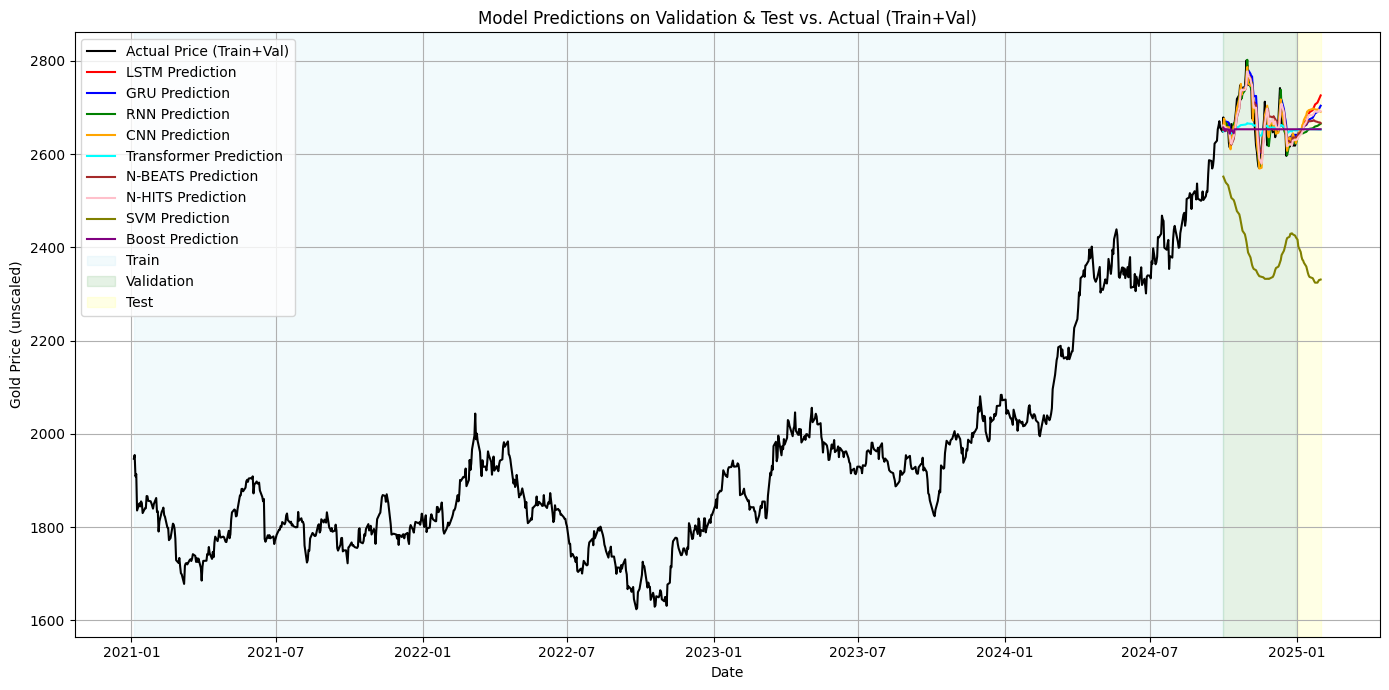

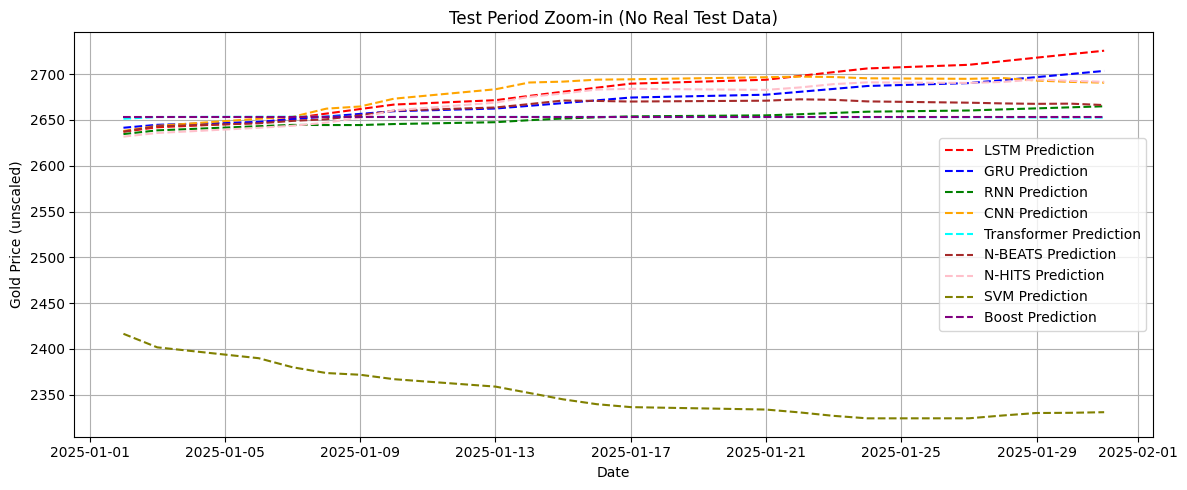

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
from sklearn.metrics import mean_absolute_percentage_error

# Additional imports for the appended models:
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
import joblib

# ------------------------------------------------------------------------
# 1. Set random seeds
# ------------------------------------------------------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

###############################################################
# Global hyperparameters
###############################################################
WINDOW_SIZE = 60
NUM_EPOCHS  = 1500

###############################################################
# 2. Load & Clean CSV
###############################################################
features = ["Price", "Open", "High", "Low"]
csv_file = "Gold Futures Historical Data_5Yr_Blind Test.csv"

df = pd.read_csv(csv_file)

# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Drop columns we don't need
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

# Remove commas and parse numeric
for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values(by="Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in df:", len(df))
print("Rows that have all features = NaN:",
      df[features].isna().all(axis=1).sum())

# ------------------------------------------------------------------------
# 3. Date cutoffs: TRAIN, VAL, TEST
# ------------------------------------------------------------------------
train_cutoff = pd.to_datetime("2024-10-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-02")

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

# ------------------------------------------------------------------------
# 4. Fit MinMaxScaler on TRAIN only
# ------------------------------------------------------------------------
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

df_val_no_nan = df_val_scaled.dropna(subset=features)
if not df_val_no_nan.empty:
    df_val_scaled.loc[df_val_no_nan.index, features] = scaler.transform(df_val_no_nan[features])

train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------------------------
# 5A. Create the training sequences
# ------------------------------------------------------------------------
def make_sequences(df_subset, window=WINDOW_SIZE):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window : i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

# Build training data using only scaled rows that have non-NaN features
train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)

X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# For sklearn-based models we flatten the time window.
X_train_flat = X_train_all.reshape((X_train_all.shape[0], WINDOW_SIZE * 4))
# y_train_all remains the same shape: (n_samples, 4)

# ------------------------------------------------------------------------
# 5B. "Half-blind" validation function
# ------------------------------------------------------------------------
def half_blind_validation_loss(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = df_work.loc[val_mask, "Date"].unique()
    val_dates = np.sort(val_dates)

    model.eval()
    criterion = nn.MSELoss()

    losses = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue

            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue

            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu()[0]

            true_vals = df_work.loc[idx_current, features]
            true_vals = pd.to_numeric(true_vals, errors="coerce").astype(float)
            true_vals = true_vals.values
            if np.isnan(true_vals).any():
                continue

            loss = criterion(pred_4_scaled, torch.tensor(true_vals).float())
            losses.append(loss.item())

    if len(losses) == 0:
        return 999999.0
    return np.mean(losses)

# ------------------------------------------------------------------------
# 5C. "Half-blind" validation predictions (to visualize model in val set)
# ------------------------------------------------------------------------
def half_blind_validation_preds(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    """Return a DataFrame of day-by-day predictions for the validation set."""
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = df_work.loc[val_mask, "Date"].unique()
    val_dates = np.sort(val_dates)

    model.eval()
    preds = []  # store day, predicted scaled[4]

    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue

            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue

            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu().numpy()[0]

            preds.append((d, *pred_4_scaled))

    val_pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Val_Pred_Price_scl", "Val_Pred_Open_scl",
                 "Val_Pred_High_scl",  "Val_Pred_Low_scl"]
    )
    val_pred_df.sort_values("Date", inplace=True)
    scaled_array = val_pred_df[["Val_Pred_Price_scl", "Val_Pred_Open_scl",
                                "Val_Pred_High_scl",  "Val_Pred_Low_scl"]].values
    unscaled_array = scaler.inverse_transform(scaled_array)

    val_pred_df["Val_Pred_Price_unsc"] = unscaled_array[:,0]
    val_pred_df["Val_Pred_Open_unsc"]  = unscaled_array[:,1]
    val_pred_df["Val_Pred_High_unsc"]  = unscaled_array[:,2]
    val_pred_df["Val_Pred_Low_unsc"]   = unscaled_array[:,3]

    return val_pred_df

# ------------------------------------------------------------------------
# 6. Define the model class with dynamic CNN out-len and appended model types
# ------------------------------------------------------------------------
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=WINDOW_SIZE):
        super().__init__()
        self.model_type = model_type
        self.window_width = window_width

        if model_type == "CNN":
            # Two conv layers, kernel_size=3 (no padding, stride=1)
            self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            with torch.no_grad():
                dummy_input = torch.zeros(1, 4, self.window_width)
                dummy_output = self.conv2(F.relu(self.conv1(dummy_input)))
                conv_output_size = dummy_output.shape[1] * dummy_output.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)

        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=2,
                               batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "RNN":
            self.rnn = nn.RNN(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, nonlinearity="relu", dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=3,
                               batch_first=True, dropout=0.2)
            self.bn = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(128, 4)
        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.1)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc = nn.Linear(128, 4)
        elif model_type == "N-BEATS":
            self.input_size = WINDOW_SIZE * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        elif model_type == "N-HITS":
            self.input_size = WINDOW_SIZE * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        else:
            raise ValueError("Invalid model_type")

    def forward(self, x):
        # x: [batch, window_width, 4]
        if self.model_type == "CNN":
            x = x.permute(0, 2, 1)  # [batch, channels=4, seq_len=window_width]
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == "LSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "GRU":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "RNN":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "EnhancedLSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        elif self.model_type == "Transformer":
            x = self.input_linear(x)         # [batch, window, 128]
            x = x.permute(1, 0, 2)             # [window, batch, 128] for transformer
            x = self.transformer_encoder(x)
            x = x[-1, :, :]                   # take last time step
            out = self.fc(x)
        elif self.model_type == "N-BEATS":
            x_flat = x.reshape(x.size(0), -1)  # Changed from .view() to .reshape()
            forecast = 0
            for block in self.blocks:
                forecast = forecast + block(x_flat)
            out = forecast
        elif self.model_type == "N-HITS":
            x_flat = x.reshape(x.size(0), -1)  # Changed from .view() to .reshape()
            forecast = 0
            for block in self.blocks:
                forecast = forecast + block(x_flat)
            out = forecast
        else:
            raise ValueError("Invalid model_type")
        return out

class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ------------------------------------------------------------------------
# 7. Inverse transform helper
# ------------------------------------------------------------------------
def inverse_transform_4cols(y_4):
    return scaler.inverse_transform(y_4)

# ------------------------------------------------------------------------
# 8. Training function for PyTorch models
# ------------------------------------------------------------------------
def train_model(model_type="LSTM", num_epochs=NUM_EPOCHS):
    """
    Builds a PyTorch model of the chosen type with window=WINDOW_SIZE,
    trains for num_epochs, and returns the best model.
    """
    model = BaseModel(model_type, window_width=WINDOW_SIZE).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=150)
    early_stopping = EarlyStopping(patience=150)

    best_val_loss = float("inf")
    best_path = f"best_{model_type}_Model_Opt_V1.pt"

    if os.path.exists(best_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_path, map_location=device))
        print(f"[{model_type}] Loaded existing model from {best_path}")

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        val_loss = half_blind_validation_loss(
            model,
            df_scaled,
            val_start=train_cutoff,
            val_end=val_cutoff,
            window=WINDOW_SIZE
        )
        scheduler.step(val_loss)
        early_stopping(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_path)

        if early_stopping.early_stop:
            print(f"[{model_type}] Early stopping at epoch {epoch+1}")
            break

        if (epoch + 1) % 100 == 0:
            print(f"[{model_type}] Epoch {epoch+1}, Train={avg_train_loss:.6f}, Val={val_loss:.6f}")

    model.load_state_dict(torch.load(best_path, map_location=device))
    return model

# ------------------------------------------------------------------------
# 8B. Training function for sklearn-based models (SVM, GPR, Boost)
# ------------------------------------------------------------------------
class SklearnWrapper:
    def __init__(self, model):
        self.model = model

    def forward(self, x):
        # x: [1, window, 4] tensor; flatten to [1, window*4]
        x_np = x.cpu().detach().numpy().reshape(1, -1)
        pred = self.model.predict(x_np)  # shape: (1, 4)
        return torch.from_numpy(pred).float().to(x.device)

    def eval(self):
        pass

    def __call__(self, x):
        return self.forward(x)

def train_model_sklearn(model_type, X_train_flat, y_train):
    """
    Trains an sklearn model wrapped for multi-output regression.
    model_type should be one of: "SVM", "GPR", "Boost"
    """
    best_path = f"best_{model_type}_Model_Opt_V1.pkl"
    if os.path.exists(best_path):
        model = joblib.load(best_path)
        print(f"[{model_type}] Loaded existing model from {best_path}")
    else:
        if model_type == "SVM":
            base_model = SVR()
        elif model_type == "GPR":
            base_model = GaussianProcessRegressor()
        elif model_type == "Boost":
            base_model = XGBRegressor(objective="reg:squarederror", n_estimators=100)
        else:
            raise ValueError("Unsupported sklearn model type")
        multi_model = MultiOutputRegressor(base_model)
        multi_model.fit(X_train_flat, y_train)
        joblib.dump(multi_model, best_path)
        model = multi_model
    return SklearnWrapper(model)

# ------------------------------------------------------------------------
# 9. Validation predictions + Test predictions
# ------------------------------------------------------------------------
def half_blind_validation_preds_df(model, df_all_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = df_work.loc[val_mask, "Date"].unique()
    val_dates = np.sort(val_dates)

    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue

            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue

            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_4_scaled))

    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)

    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = inverse_transform_4cols(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]

    return pred_df

def walk_forward_test(model, df_all_scaled, test_start, window=WINDOW_SIZE):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    preds = []
    test_dates = df_work[df_work["Date"] >= test_start]["Date"].unique()
    test_dates = np.sort(test_dates)

    model.eval()
    with torch.no_grad():
        for d in test_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue

            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue

            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            y_pred_4_scaled = model(X_input).cpu().numpy()[0]

            df_work.loc[idx_current, features] = y_pred_4_scaled
            preds.append((d, *y_pred_4_scaled))

    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)

    scaled_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = inverse_transform_4cols(scaled_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:,0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:,1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:,2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:,3]

    return pred_df

# ------------------------------------------------------------------------
# 10. Evaluate & Plot
# ------------------------------------------------------------------------
def evaluate_and_plot_all_models(results_dict):
    df_real = df_scaled[["Date","Price","Open","High","Low"]].copy()
    df_real.sort_values("Date", inplace=True)

    mask_trainval = (df_real["Date"] < test_cutoff)
    df_real_plot = df_real.loc[mask_trainval].copy()
    real_4_scaled = df_real_plot[features].values
    real_4_unscaled = inverse_transform_4cols(real_4_scaled)
    df_real_plot["Real_Price_unscaled"] = real_4_unscaled[:,0]

    plt.figure(figsize=(14,7))
    plt.plot(df_real_plot["Date"], df_real_plot["Real_Price_unscaled"],
             color="black", label="Actual Price (Train+Val)")

    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }

    merged_df = df_real.copy()
    merged_df.sort_values("Date", inplace=True)

    for model_name, info in results_dict.items():
        val_pred_df = info["val_pred_df"]
        test_pred_df = info["test_pred_df"]

        frames = []
        if val_pred_df is not None:
            frames.append(val_pred_df.rename(columns={
                "Pred_Price_unscaled": f"Pred_{model_name}",
            }))
        if test_pred_df is not None:
            frames.append(test_pred_df.rename(columns={
                "Pred_Price_unscaled": f"Pred_{model_name}",
            }))
        if not frames:
            continue
        combined_df = pd.concat(frames, ignore_index=True)
        combined_df = combined_df[["Date", f"Pred_{model_name}"]].copy()
        combined_df.drop_duplicates("Date", keep="last", inplace=True)
        combined_df.sort_values("Date", inplace=True)

        merged_df = pd.merge(merged_df, combined_df, on="Date", how="left")

    for model_name, info in results_dict.items():
        col = f"Pred_{model_name}"
        if col in merged_df.columns:
            plt.plot(
                merged_df["Date"],
                merged_df[col],
                color=color_map.get(model_name, "gray"),
                linestyle="-",
                label=f"{model_name} Prediction"
            )

    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, merged_df["Date"].max(), color="yellow", alpha=0.1, label="Test")

    plt.title("Model Predictions on Validation & Test vs. Actual (Train+Val)")
    plt.xlabel("Date")
    plt.ylabel("Gold Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    df_test_zoom = merged_df[merged_df["Date"] >= test_cutoff]
    if not df_test_zoom.empty:
        plt.figure(figsize=(12,5))
        for model_name, info in results_dict.items():
            col = f"Pred_{model_name}"
            if col in df_test_zoom.columns:
                plt.plot(
                    df_test_zoom["Date"],
                    df_test_zoom[col],
                    color=color_map.get(model_name, "gray"),
                    linestyle="--",
                    label=f"{model_name} Prediction"
                )

        plt.title("Test Period Zoom-in (No Real Test Data)")
        plt.xlabel("Date")
        plt.ylabel("Gold Price (unscaled)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ------------------------------------------------------------------------
# 11. MAIN
# ------------------------------------------------------------------------
if __name__ == "__main__":
    # List of all models to run (both PyTorch and sklearn-based)
    all_model_types = ["LSTM", "GRU", "RNN", "CNN", "Transformer", "N-BEATS", "N-HITS", "SVM", "Boost"]
    results_dict = {}

    for mt in all_model_types:
        print(f"\n=== Training {mt} model ===")
        # For sklearn-based models, use the dedicated training function.
        if mt in ["SVM", "GPR", "Boost"]:
            model = train_model_sklearn(mt, X_train_flat, y_train_all)
        else:
            model = train_model(mt, num_epochs=NUM_EPOCHS)

        val_pred_df = half_blind_validation_preds_df(
            model,
            df_scaled,
            val_start=train_cutoff,
            val_end=val_cutoff,
            window=WINDOW_SIZE
        )
        test_pred_df = walk_forward_test(
            model,
            df_all_scaled=df_scaled,
            test_start=test_cutoff,
            window=WINDOW_SIZE
        )

        results_dict[mt] = {
            "val_pred_df": val_pred_df,
            "test_pred_df": test_pred_df
        }
        print(f"{mt} has no real test data => skip MAPE")

    evaluate_and_plot_all_models(results_dict)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
from sklearn.metrics import mean_absolute_percentage_error

# Additional imports for the appended models:
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
import joblib

# ------------------------------------------------------------------------
# 1. Set random seeds
# ------------------------------------------------------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

###############################################################
# Global hyperparameters
###############################################################
WINDOW_SIZE = 60
NUM_EPOCHS  = 500

###############################################################
# 2. Load & Clean CSV
###############################################################
features = ["Price", "Open", "High", "Low"]
csv_file = "Gold Futures Historical Data_5Yr_Blind Test.csv"

df = pd.read_csv(csv_file)

# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Drop columns we don't need
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

# Remove commas and parse numeric
for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values(by="Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in df:", len(df))
print("Rows that have all features = NaN:",
      df[features].isna().all(axis=1).sum())

# ------------------------------------------------------------------------
# 3. Date cutoffs: TRAIN, VAL, TEST
# ------------------------------------------------------------------------
train_cutoff = pd.to_datetime("2024-08-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-02")

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

# ------------------------------------------------------------------------
# 4. Fit MinMaxScaler on TRAIN only
# ------------------------------------------------------------------------
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

df_val_no_nan = df_val_scaled.dropna(subset=features)
if not df_val_no_nan.empty:
    df_val_scaled.loc[df_val_no_nan.index, features] = scaler.transform(df_val_no_nan[features])

train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------------------------
# 5A. Create the training sequences
# ------------------------------------------------------------------------
def make_sequences(df_subset, window=WINDOW_SIZE):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window : i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

# Build training data using only scaled rows that have non-NaN features
train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)

X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# For sklearn-based models we flatten the time window.
X_train_flat = X_train_all.reshape((X_train_all.shape[0], WINDOW_SIZE * 4))
# y_train_all remains the same shape: (n_samples, 4)

# ------------------------------------------------------------------------
# 5B. "Half-blind" validation function
# ------------------------------------------------------------------------
def half_blind_validation_loss(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = df_work.loc[val_mask, "Date"].unique()
    val_dates = np.sort(val_dates)

    model.eval()
    criterion = nn.MSELoss()

    losses = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue

            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue

            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu()[0]

            true_vals = df_work.loc[idx_current, features]
            true_vals = pd.to_numeric(true_vals, errors="coerce").astype(float)
            true_vals = true_vals.values
            if np.isnan(true_vals).any():
                continue

            loss = criterion(pred_4_scaled, torch.tensor(true_vals).float())
            losses.append(loss.item())

    if len(losses) == 0:
        return 999999.0
    return np.mean(losses)

# ------------------------------------------------------------------------
# 5C. "Half-blind" validation predictions (to visualize model in val set)
# ------------------------------------------------------------------------
def half_blind_validation_preds(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    """Return a DataFrame of day-by-day predictions for the validation set."""
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = df_work.loc[val_mask, "Date"].unique()
    val_dates = np.sort(val_dates)

    model.eval()
    preds = []  # store day, predicted scaled[4]

    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue

            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue

            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu().numpy()[0]

            preds.append((d, *pred_4_scaled))

    val_pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Val_Pred_Price_scl", "Val_Pred_Open_scl",
                 "Val_Pred_High_scl",  "Val_Pred_Low_scl"]
    )
    val_pred_df.sort_values("Date", inplace=True)
    scaled_array = val_pred_df[["Val_Pred_Price_scl", "Val_Pred_Open_scl",
                                "Val_Pred_High_scl",  "Val_Pred_Low_scl"]].values
    unscaled_array = scaler.inverse_transform(scaled_array)

    val_pred_df["Val_Pred_Price_unsc"] = unscaled_array[:,0]
    val_pred_df["Val_Pred_Open_unsc"]  = unscaled_array[:,1]
    val_pred_df["Val_Pred_High_unsc"]  = unscaled_array[:,2]
    val_pred_df["Val_Pred_Low_unsc"]   = unscaled_array[:,3]

    return val_pred_df

# ------------------------------------------------------------------------
# 6. Define the model class with dynamic CNN out-len and appended model types
# ------------------------------------------------------------------------
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=WINDOW_SIZE):
        super().__init__()
        self.model_type = model_type
        self.window_width = window_width

        if model_type == "CNN":
            # Two conv layers, kernel_size=3 (no padding, stride=1)
            self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            with torch.no_grad():
                dummy_input = torch.zeros(1, 4, self.window_width)
                dummy_output = self.conv2(F.relu(self.conv1(dummy_input)))
                conv_output_size = dummy_output.shape[1] * dummy_output.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)

        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=2,
                               batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "RNN":
            self.rnn = nn.RNN(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, nonlinearity="relu", dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=3,
                               batch_first=True, dropout=0.2)
            self.bn = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(128, 4)
        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.1)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc = nn.Linear(128, 4)
        elif model_type == "N-BEATS":
            self.input_size = WINDOW_SIZE * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        elif model_type == "N-HITS":
            self.input_size = WINDOW_SIZE * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        else:
            raise ValueError("Invalid model_type")

    def forward(self, x):
        # x: [batch, window_width, 4]
        if self.model_type == "CNN":
            x = x.permute(0, 2, 1)  # [batch, channels=4, seq_len=window_width]
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == "LSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "GRU":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "RNN":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "EnhancedLSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        elif self.model_type == "Transformer":
            x = self.input_linear(x)         # [batch, window, 128]
            x = x.permute(1, 0, 2)             # [window, batch, 128] for transformer
            x = self.transformer_encoder(x)
            x = x[-1, :, :]                   # take last time step
            out = self.fc(x)
        elif self.model_type == "N-BEATS":
            x_flat = x.reshape(x.size(0), -1)  # Changed from .view() to .reshape()
            forecast = 0
            for block in self.blocks:
                forecast = forecast + block(x_flat)
            out = forecast
        elif self.model_type == "N-HITS":
            x_flat = x.reshape(x.size(0), -1)  # Changed from .view() to .reshape()
            forecast = 0
            for block in self.blocks:
                forecast = forecast + block(x_flat)
            out = forecast
        else:
            raise ValueError("Invalid model_type")
        return out

class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ------------------------------------------------------------------------
# 7. Inverse transform helper
# ------------------------------------------------------------------------
def inverse_transform_4cols(y_4):
    return scaler.inverse_transform(y_4)

# ------------------------------------------------------------------------
# 8. Training function for PyTorch models
# ------------------------------------------------------------------------
def train_model(model_type="LSTM", num_epochs=NUM_EPOCHS):
    """
    Builds a PyTorch model of the chosen type with window=WINDOW_SIZE,
    trains for num_epochs, and returns the best model.
    """
    model = BaseModel(model_type, window_width=WINDOW_SIZE).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=150)
    early_stopping = EarlyStopping(patience=150)

    best_val_loss = float("inf")
    best_path = f"best_{model_type}_Model_Opt_V2.pt"

    if os.path.exists(best_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_path, map_location=device))
        print(f"[{model_type}] Loaded existing model from {best_path}")

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        val_loss = half_blind_validation_loss(
            model,
            df_scaled,
            val_start=train_cutoff,
            val_end=val_cutoff,
            window=WINDOW_SIZE
        )
        scheduler.step(val_loss)
        early_stopping(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_path)

        if early_stopping.early_stop:
            print(f"[{model_type}] Early stopping at epoch {epoch+1}")
            break

        if (epoch + 1) % 100 == 0:
            print(f"[{model_type}] Epoch {epoch+1}, Train={avg_train_loss:.6f}, Val={val_loss:.6f}")

    model.load_state_dict(torch.load(best_path, map_location=device))
    return model

# ------------------------------------------------------------------------
# 8B. Training function for sklearn-based models (SVM, GPR, Boost)
# ------------------------------------------------------------------------
class SklearnWrapper:
    def __init__(self, model):
        self.model = model

    def forward(self, x):
        # x: [1, window, 4] tensor; flatten to [1, window*4]
        x_np = x.cpu().detach().numpy().reshape(1, -1)
        pred = self.model.predict(x_np)  # shape: (1, 4)
        return torch.from_numpy(pred).float().to(x.device)

    def eval(self):
        pass

    def __call__(self, x):
        return self.forward(x)

def train_model_sklearn(model_type, X_train_flat, y_train):
    """
    Trains an sklearn model wrapped for multi-output regression.
    model_type should be one of: "SVM", "GPR", "Boost"
    """
    best_path = f"best_{model_type}_Model_Opt_V1.pkl"
    if os.path.exists(best_path):
        model = joblib.load(best_path)
        print(f"[{model_type}] Loaded existing model from {best_path}")
    else:
        if model_type == "SVM":
            base_model = SVR()
        elif model_type == "GPR":
            base_model = GaussianProcessRegressor()
        elif model_type == "Boost":
            base_model = XGBRegressor(objective="reg:squarederror", n_estimators=100)
        else:
            raise ValueError("Unsupported sklearn model type")
        multi_model = MultiOutputRegressor(base_model)
        multi_model.fit(X_train_flat, y_train)
        joblib.dump(multi_model, best_path)
        model = multi_model
    return SklearnWrapper(model)

# ------------------------------------------------------------------------
# 9. Validation predictions + Test predictions
# ------------------------------------------------------------------------
def half_blind_validation_preds_df(model, df_all_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = df_work.loc[val_mask, "Date"].unique()
    val_dates = np.sort(val_dates)

    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue

            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue

            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_4_scaled))

    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)

    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = inverse_transform_4cols(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]

    return pred_df

def walk_forward_test(model, df_all_scaled, test_start, window=WINDOW_SIZE):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    preds = []
    test_dates = df_work[df_work["Date"] >= test_start]["Date"].unique()
    test_dates = np.sort(test_dates)

    model.eval()
    with torch.no_grad():
        for d in test_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue

            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue

            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            y_pred_4_scaled = model(X_input).cpu().numpy()[0]

            df_work.loc[idx_current, features] = y_pred_4_scaled
            preds.append((d, *y_pred_4_scaled))

    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)

    scaled_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = inverse_transform_4cols(scaled_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:,0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:,1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:,2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:,3]

    return pred_df

# ------------------------------------------------------------------------
# 10. Evaluate & Plot
# ------------------------------------------------------------------------
def evaluate_and_plot_all_models(results_dict):
    df_real = df_scaled[["Date","Price","Open","High","Low"]].copy()
    df_real.sort_values("Date", inplace=True)

    mask_trainval = (df_real["Date"] < test_cutoff)
    df_real_plot = df_real.loc[mask_trainval].copy()
    real_4_scaled = df_real_plot[features].values
    real_4_unscaled = inverse_transform_4cols(real_4_scaled)
    df_real_plot["Real_Price_unscaled"] = real_4_unscaled[:,0]

    plt.figure(figsize=(14,7))
    plt.plot(df_real_plot["Date"], df_real_plot["Real_Price_unscaled"],
             color="black", label="Actual Price (Train+Val)")

    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }

    merged_df = df_real.copy()
    merged_df.sort_values("Date", inplace=True)

    for model_name, info in results_dict.items():
        val_pred_df = info["val_pred_df"]
        test_pred_df = info["test_pred_df"]

        frames = []
        if val_pred_df is not None:
            frames.append(val_pred_df.rename(columns={
                "Pred_Price_unscaled": f"Pred_{model_name}",
            }))
        if test_pred_df is not None:
            frames.append(test_pred_df.rename(columns={
                "Pred_Price_unscaled": f"Pred_{model_name}",
            }))
        if not frames:
            continue
        combined_df = pd.concat(frames, ignore_index=True)
        combined_df = combined_df[["Date", f"Pred_{model_name}"]].copy()
        combined_df.drop_duplicates("Date", keep="last", inplace=True)
        combined_df.sort_values("Date", inplace=True)

        merged_df = pd.merge(merged_df, combined_df, on="Date", how="left")

    for model_name, info in results_dict.items():
        col = f"Pred_{model_name}"
        if col in merged_df.columns:
            plt.plot(
                merged_df["Date"],
                merged_df[col],
                color=color_map.get(model_name, "gray"),
                linestyle="-",
                label=f"{model_name} Prediction"
            )

    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, merged_df["Date"].max(), color="yellow", alpha=0.1, label="Test")

    plt.title("Model Predictions on Validation & Test vs. Actual (Train+Val)")
    plt.xlabel("Date")
    plt.ylabel("Gold Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    df_test_zoom = merged_df[merged_df["Date"] >= test_cutoff]
    if not df_test_zoom.empty:
        plt.figure(figsize=(12,5))
        for model_name, info in results_dict.items():
            col = f"Pred_{model_name}"
            if col in df_test_zoom.columns:
                plt.plot(
                    df_test_zoom["Date"],
                    df_test_zoom[col],
                    color=color_map.get(model_name, "gray"),
                    linestyle="--",
                    label=f"{model_name} Prediction"
                )

        plt.title("Test Period Zoom-in (No Real Test Data)")
        plt.xlabel("Date")
        plt.ylabel("Gold Price (unscaled)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ------------------------------------------------------------------------
# 11. MAIN
# ------------------------------------------------------------------------
if __name__ == "__main__":
    # List of all models to run (both PyTorch and sklearn-based)
    all_model_types = ["LSTM", "GRU", "RNN", "CNN", "Transformer", "N-BEATS", "N-HITS", "SVM", "Boost"]
    results_dict = {}

    for mt in all_model_types:
        print(f"\n=== Training {mt} model ===")
        # For sklearn-based models, use the dedicated training function.
        if mt in ["SVM", "GPR", "Boost"]:
            model = train_model_sklearn(mt, X_train_flat, y_train_all)
        else:
            model = train_model(mt, num_epochs=NUM_EPOCHS)

        val_pred_df = half_blind_validation_preds_df(
            model,
            df_scaled,
            val_start=train_cutoff,
            val_end=val_cutoff,
            window=WINDOW_SIZE
        )
        test_pred_df = walk_forward_test(
            model,
            df_all_scaled=df_scaled,
            test_start=test_cutoff,
            window=WINDOW_SIZE
        )

        results_dict[mt] = {
            "val_pred_df": val_pred_df,
            "test_pred_df": test_pred_df
        }
        print(f"{mt} has no real test data => skip MAPE")

    evaluate_and_plot_all_models(results_dict)
